In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

from surp import subgiants, yields
from surp import gce_math as gcem
from surp._globals import AGB_MODELS

import arya

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import surp

In [4]:
from surp.yield_models import C_AGB_Model

In [5]:
A_agb = 0.0068371209
τo = 11
m_up = 3.411

y_c_agb_0 = 0.0042

def y_agb(m, z):
    return y_c_agb_0*np.where(m > m_up, 0, 
        1/A_agb * (
            m**-3.2
            * (τo * m**-3.5 - t_d)
            * np.exp(
                -(τo * m**-3.5 - t_d) / τa
            )
        )
    )

In [6]:
def plot_ssp(M_H_min = -2.5, M_H_max=0.5, **kwargs):
    Zs = 0.014*10**np.linspace(M_H_min, M_H_max, 100)
    mass_yields = []
    
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])

    plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6), **kwargs)
    
    plt.xlabel(r"$\log_{10} Z\,/\,Z_{\odot}$")
    plt.ylabel(r"$y_{\rm C}^{\rm AGB}$")

In [7]:
ana_params = surp.YieldParams.from_file("../../models/analytic/yield_params.toml")

In [8]:
ana_params.alpha_c_agb = 1

In [9]:
surp.set_yields(ana_params)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  (3.80e-04 + -3.50e-04(Z-Zo)),  0.00e+00                       
                    2.20e-03                       t_D=0.15, tau=0.30                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [10]:
a_agb = surp.yields.agb.settings["c"]

In [11]:
a_agb.y0

0.00038

In [12]:
surp.yields.calc_y(kind="agb")

0.000377819006719278

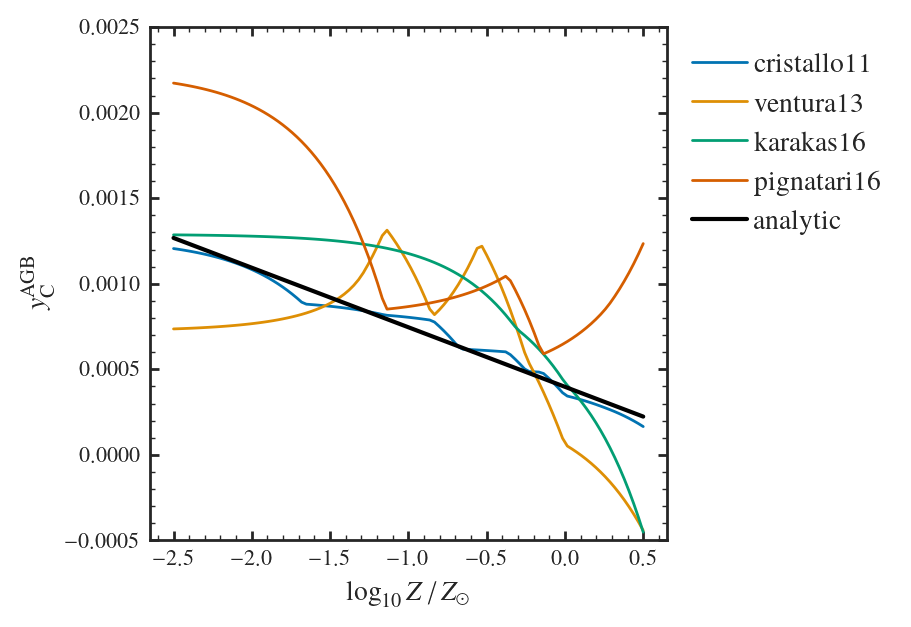

In [13]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0

for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_ssp(label=model)


vice.yields.agb.settings["c"] = a_agb
plot_ssp(label="analytic", color="k", lw=1.5)
plt.ylim(-0.0005, 0.0025)

arya.Legend(loc=-1)

# plt.savefig("agb_ana_vs_z.pdf")

In [14]:
def plot_dtd(ele="c", Z=0.014, **kwargs):
    m_c, times = vice.single_stellar_population(ele, Z=Z)
    m_c = np.array(m_c)
    y = m_c/m_c[-1]
    plt.plot(times, y, **kwargs)
    
    plt.xlabel(r"$t\,/\,{\rm Gyr}$")
    plt.ylabel(r"$M(t)\,/\,M_{\rm tot}$")

In [15]:
def plot_fe_dtd():
    vice.yields.ccsne.settings["fe"] = 0

    m_fe, times = vice.single_stellar_population("fe", Z=0.014)
    m_fe = [fe for fe in m_fe]
    plt.plot(times, np.array(m_fe)/m_fe[-1], label="SNe Ia Fe",
             linestyle="--", color="k")
    


In [16]:
def plot_c_fe(Z = 0.014, f_agb=0.2, f_ia=0.5, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, dt=0.005)
    m_fe, times = vice.single_stellar_population("fe", Z=Z, dt=0.005)

    discard = 50
    m_c = np.array(m_c)/m_c[-1]
    m_fe = np.array(m_fe)/m_fe[-1]
    f_c = m_c * f_agb + 1-f_agb
    f_fe = m_fe * f_ia + 1-f_ia
    x=np.log10(f_fe)
    y = np.log10(f_c)
    plt.plot(x, y, **kwargs)

    plt.xlim(0.1, -0.5)
    plt.ylim(-0.3, 0.1)
    plt.xlabel(r"$\log {\rm Fe}(t)$")
    plt.ylabel(r"$\log {\rm C}(t)$")

([<matplotlib.axis.XTick at 0x7f1d3d3c3fd0>,
 [Text(0.1, 0, '0.1'), Text(1.0, 0, '1'), Text(10.0, 0, '10')])

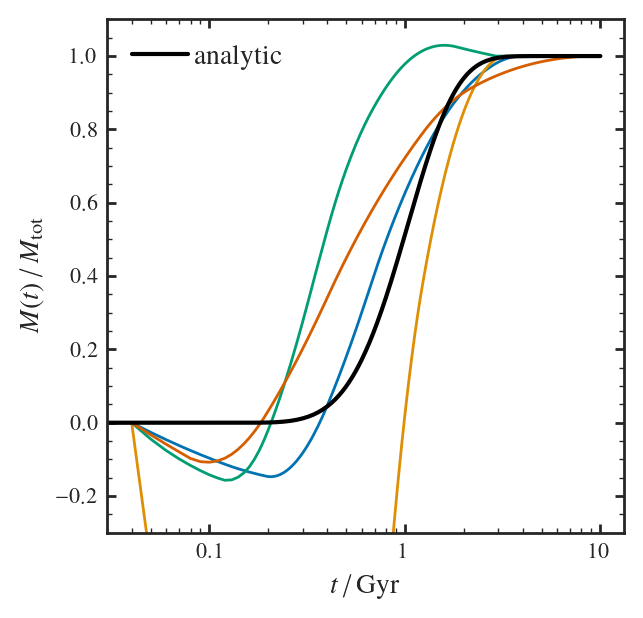

In [17]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0


for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_dtd()

vice.yields.agb.settings["c"] = a_agb
plot_dtd(label="analytic", color="k", lw=1.5)

plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

# plt.savefig("agb_ana_dtd.pdf")

In [31]:
def compare_dtd_to_ana(model, study="cristallo11", Zs=[0.001, 0.003, 0.014, 0.03]):
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.sneia.settings["c"] = 0
    plt.figure(figsize=(10/3, 10/3))

    hm = arya.HueMap(clim=(0, len(Zs)))
    
    for i, Z in enumerate(Zs):
        vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", study=study)
        plot_dtd(color=hm(i), Z=Z)
        
        vice.yields.agb.settings["c"] = model
        plot_dtd(Z=Z, color=hm(i), ls=":")
    
    plt.xscale("log")
    plt.ylim(-0.3, 1.1)
    plt.xlim(0.03, 13.2)
    plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

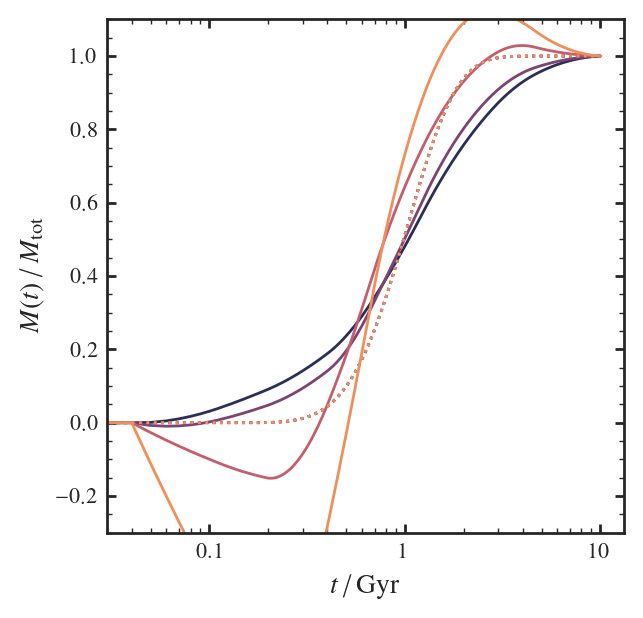

In [32]:
compare_dtd_to_ana(C_AGB_Model(tau_agb=0.3, m_low=0), study="cristallo11")

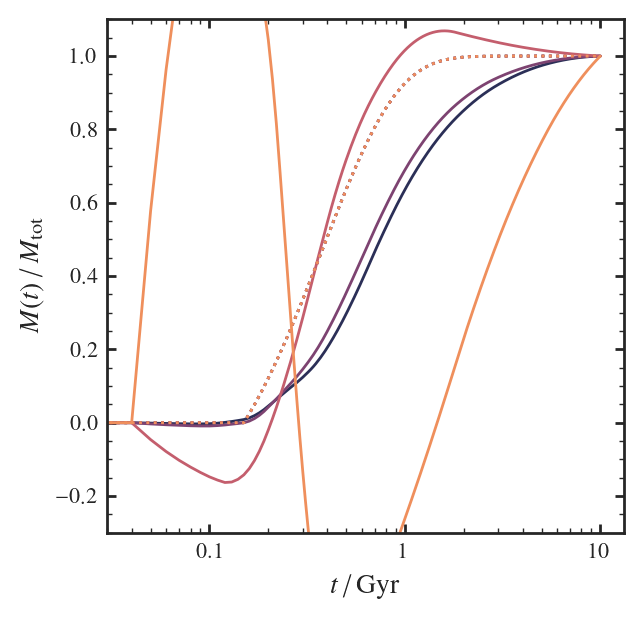

In [33]:
compare_dtd_to_ana(C_AGB_Model(tau_agb=0.3, gamma=0, m_low=0), study="karakas16")

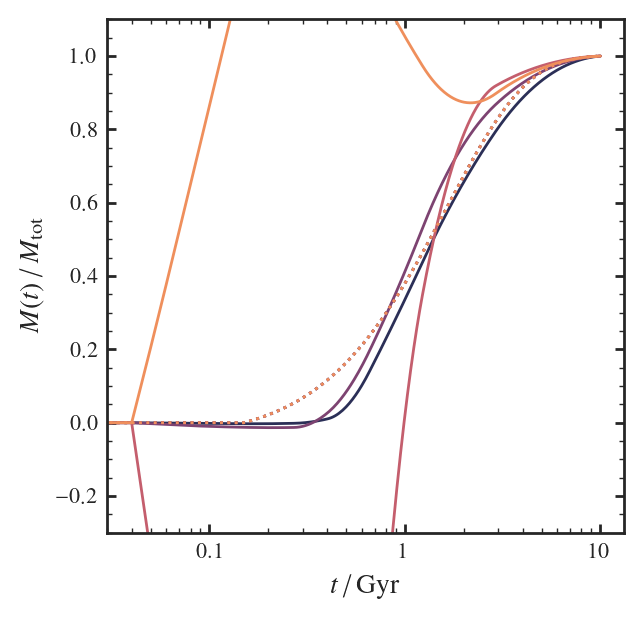

In [37]:
compare_dtd_to_ana(C_AGB_Model(tau_agb=1.5, gamma=0, m_low=1), study="ventura13")

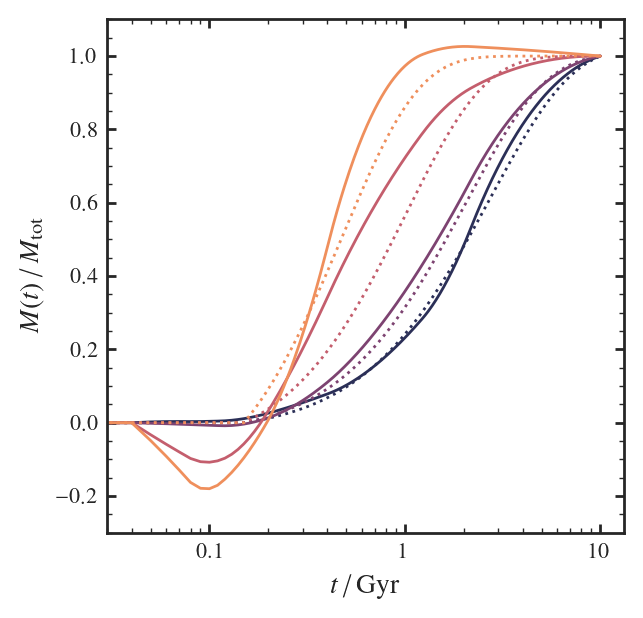

In [35]:
compare_dtd_to_ana(C_AGB_Model(tau_agb=0.8, gamma=0, zeta_tau=-1.5, m_low=0), study="pignatari16")

In [25]:
t_d = 0.15
τa = 0.3
τ = 2

def Z_c_agb(t):
    return np.where(t < t_d, 0, 
                    ((τ**3*np.exp(t/τ) - 2*τ**2*τa*np.exp(t/τ) + τ*τa**2*np.exp(t/τ) - τ**3*np.exp(t_d/τ)
            )*np.exp(t/τa) 
            + ((t - t_d)*τ**2*np.exp(t/τ) 
               - τ*τa**2*np.exp(t/τ) 
               - ((t - t_d)*τ - 2*τ**2)*τa*np.exp(t/τ)
              )*np.exp(t_d/τa))*np.exp(-t/τa)/(
        (τ**2*np.exp(t/τ) - 2*τ*τa*np.exp(t/τ) + τa**2*np.exp(t/τ))*τs)
                   )




In [26]:
τs=2.3

In [27]:
t = np.linspace(0, 13.2)

In [28]:
def sfh(tau=300):
    return lambda t: 1

def sz_model(eta=0, tau_star=3.1, t_end=13, tau_sfh=300, dt=0.005):
    sz = vice.singlezone(elements=["o", "mg", "c", "fe"], dt=dt, eta=eta, func=sfh(tau=tau_sfh), mode="ifr", tau_star=tau_star, Mg0=0)
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out


In [29]:
vice.yields.ccsne.settings["c"] = 0

In [30]:
η = 2
τ = τs / (1+η - 0.4)

In [20]:
vice.yields.agb.settings["c"] = "cristallo11"
sz = sz_model(η, τs)

In [ ]:
vice.yields.agb.settings["c"] = y_agb
sz_a = sz_model(η, τs)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,


In [ ]:
plt.plot(t, Z_c_agb(t)/Z_c_agb(13.2))

y =  sz.history["Z(c)"]
y = np.array(y)/y[-1]
plt.plot(sz.history["time"], y)

y =  sz_a.history["Z(c)"]
y = np.array(y)/y[-1]
plt.plot(sz_a.history["time"], y)

plt.xscale('log')
plt.xlim(0.1)

In [ ]:
def Z_o(t):
    return y_o * τ/τs * (1 - np.exp(-t/τ))

In [ ]:
y_o = 7.12e-3

In [ ]:
vice.yields.ccsne.settings["o"] = y_o

In [ ]:
gcem.abund_to_brak

In [ ]:
x = Z_o(t)
y = y_c_agb_0*Z_c_agb(t)
y = gcem.abund_to_brak(y/x, "c", "o")
x = gcem.abund_to_brak(x, "o")
plt.plot(x, y)

y =  sz.history["[c/o]"]
y = np.array(y)
x = sz.history["[o/h]"]
x = np.array(x)
plt.plot(x, y)

y =  sz_a.history["[c/o]"]
y = np.array(y)
x = sz_a.history["[o/h]"]
x = np.array(x)
plt.plot(x, y+1)
plt.ylim(-5)

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0

model = "cristallo11"
vice.yields.agb.settings["c"] = "cristallo11"
plot_dtd()
τa = 0.3
vice.yields.agb.settings["c"] = y_agb
plot_dtd(label="modified")

vice.yields.agb.settings["c"] = a_agb
plot_dtd(label="analytic")


plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

# plt.savefig("agb_ana_dtd.pdf")

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0

model = "cristallo11"
vice.yields.agb.settings["c"] = "cristallo11"
plot_dtd()

vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=model, no_negative=True, mass_factor=1.5)
plot_dtd(label="modified")

vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=model, no_negative=True, mass_factor=0.6)
plot_dtd(label="less")

plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

# plt.savefig("agb_ana_dtd.pdf")

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0


for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_c_fe(label=model)

    
arya.Legend(color_only=True)



In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0


for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model
    plot_c_fe(alpha=0.1, color="k")

for i in range(5):
    m_low = [1, 1, 2, 3, 4][i]
    m_high = [1.2, 2, 3, 4, 5][i]
    
    vice.yields.agb.settings["c"] = yields.C_AGB_Model()

    plot_c_fe(label=(m_low + m_high)/2, f_agb=0.3)
    
vice.yields.agb.settings["c"] = yields.C_AGB_Model()

plot_c_fe(label="fiducial", color="k")



In [ ]:
def compare_to_studies(model):
    nrows = 4
    ncols = 2
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(7, 6), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0, wspace=0)

    c1 = arya.style.COLORS[0:4]
    c2 = "k"
    
    Zs = [0.0001, 0.0003, 0.001, 0.003, 0.006, 0.01, 0.014, 0.02]
    Ms = np.linspace(1, 8, 100)

    for i in range(nrows*ncols):
        Z = Zs[i]
        ax = axs[i // ncols][i % ncols]
        plt.sca(ax)

        for j in range(4):
            f_y = vice.yields.agb.interpolator("c", study=AGB_MODELS[j])
            y = [f_y(a, Z) for a in Ms]
            plt.plot(Ms, y, color=c1[j], alpha=0.3, ls="-", zorder=2)

        y = [model(a, Z) for a in Ms]
        plt.plot(Ms, y, color=c2, zorder=1)

        plt.text(0.6, 0.8, "$Z=%0.4f$" % Z, transform=ax.transAxes)


    fig.supylabel(r'$y_{\rm C}^{\rm AGB}$')
    fig.supxlabel(r'$M\,/\,M_{\odot}$')



In [ ]:
compare_to_studies(a_agb)